In [6]:
import time
import torch
from torch.distributions import Categorical, kl
from d2l.torch import Animator

from net import Net
from aco import ACO
from utils import gen_pyg_data, load_val_dataset

torch.manual_seed(1234)

lr = 3e-4
EPS = 1e-10
ALPHA = 0.05
T_max = 250
T_update = 50 # in this case, we regenerate heuristic measures in T=50, 100, 150, 200
device = 'cuda:0'

In [7]:
def entropy(phe_mat, heu_mat, k_sparse):
    entropy = torch.sum(Categorical(phe_mat * heu_mat).entropy()) / k_sparse
    return entropy

def train_instance(model, optimizer, pyg_data, distances, n_ants, k_sparse, run_aco=False):
    model.train()
    aco = ACO(n_ants=n_ants, distances=distances, device=device)
    if not run_aco:
        heu_vec = model(pyg_data, 0) # using the first decoder head
        heu_mat = model.reshape(pyg_data, heu_vec) + EPS
        aco.heuristic = heu_mat
        costs, log_probs = aco.sample()
        baseline = costs.mean()
        reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
        entropy_loss = - ALPHA * entropy(aco.pheromone, heu_mat, k_sparse)
        loss = reinforce_loss + entropy_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    else:
        model.freeze_gnn()
        heu_vec = model(pyg_data, 0) # using the first decoder head
        heu_mat = model.reshape(pyg_data, heu_vec) + EPS
        aco.heuristic = heu_mat
        for stage in range(1, T_max // T_update):
            aco.run(T_update)
            heu_vec = model(pyg_data, stage)
            heu_mat = model.reshape(pyg_data, heu_vec) + EPS
            aco.heuristic = heu_mat
            costs, log_probs = aco.sample()
            baseline = costs.mean()
            reinforce_loss = torch.sum((costs - baseline) * log_probs.sum(dim=0)) / aco.n_ants
            entropy_loss = ((T_max - (stage+1) * T_update) / T_max) * ALPHA * entropy(aco.pheromone, heu_mat, k_sparse)
            loss = reinforce_loss + entropy_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()                

def infer_instance(model, pyg_data, distances, n_ants, run_aco):
    model.eval()
    stage = 1 if run_aco else 0
    heu_vec = model(pyg_data, stage)
    heu_mat = model.reshape(pyg_data, heu_vec) + EPS
    aco = ACO(
        n_ants=n_ants,
        heuristic=heu_mat,
        distances=distances,
        device=device
        )
    costs, log_probs = aco.sample()
    baseline = costs.mean()
    best_sample_cost = torch.min(costs)
    return baseline.item(), best_sample_cost.item()

In [8]:
def train_epoch(n_node, n_ants, k_sparse, steps_per_epoch, net, optimizer, run_aco):
    for _ in range(steps_per_epoch):
        instance = torch.rand(size=(n_node, 2), device=device)
        data, distances = gen_pyg_data(instance, k_sparse=k_sparse)
        train_instance(net, optimizer, data, distances, n_ants, k_sparse, run_aco)


@torch.no_grad()
def validation(n_ants, epoch, net, val_dataset, run_aco, animator=None):
    sum_bl, sum_sample_best = 0, 0
    
    val_dataset = val_dataset[:20]
    
    for data, distances in val_dataset:
        bl, sample_best = infer_instance(net, data, distances, n_ants, run_aco)
        sum_bl += bl
        sum_sample_best += sample_best
    
    n_val = len(val_dataset)
    avg_bl, avg_sample_best = sum_bl/n_val, sum_sample_best/n_val
    if animator:
        animator.add(epoch+1, (avg_bl, avg_sample_best))
    
    return avg_bl, avg_sample_best

In [9]:
def train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, run_aco, net=None):
    if not net:
        assert not run_aco
        net = Net(T_max // T_update).to(device)
        print(sum([param.nelement() for param in net.parameters()]))
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr)
    val_list = load_val_dataset(n_node, k_sparse, device)
    animator = Animator(xlabel='epoch', xlim=[0, epochs],
                        legend=["Avg. sample obj.", "Best sample obj."])
    
    avg_bl, avg_best = validation(n_ants, -1, net, val_list, run_aco, animator)
    val_results = [(avg_bl, avg_best)]
    
    sum_time = 0
    for epoch in range(0, epochs):
        start = time.time()
        train_epoch(n_node, n_ants, k_sparse, steps_per_epoch, net, optimizer, run_aco)
        sum_time += time.time() - start
        avg_bl, avg_sample_best = validation(n_ants, epoch, net, val_list, run_aco, animator)
        val_results.append((avg_bl, avg_sample_best))
        
    print('total training duration:', sum_time)
    
    for epoch in range(-1, epochs):
        print(f'epoch {epoch}:', val_results[epoch+1])
    
    if run_aco:
        torch.save(net.state_dict(), f'../pretrained/tsp-temporal/tsp{n_node}.pt')
        
    return net

### TSP20--Stage1

total training duration: 77.76528549194336
epoch -1: (7.429802346229553, 6.2053917169570925)
epoch 0: (5.062700700759888, 4.3614088773727415)
epoch 1: (4.435193169116974, 4.006938207149505)
epoch 2: (4.476948595046997, 4.021198439598083)
epoch 3: (4.404450845718384, 3.964314615726471)
epoch 4: (4.439768218994141, 3.9486557960510256)


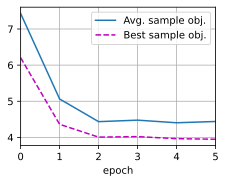

In [52]:
n_node = 20
n_ants = 20
k_sparse = 10
steps_per_epoch = 128
epochs = 5
net = train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, run_aco=False)

### TSP20-Stage2

total training duration: 1039.6919012069702
epoch -1: (7.491383743286133, 6.319629240036011)
epoch 0: (4.956836771965027, 4.240058958530426)
epoch 1: (4.594553697109222, 4.0328054308891295)
epoch 2: (4.482447826862336, 3.9762292385101317)
epoch 3: (4.401445376873016, 3.953258526325226)
epoch 4: (4.377963507175446, 3.9508626222610475)


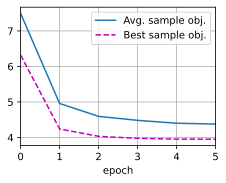

In [44]:
n_node = 20
n_ants = 20
k_sparse = 10
steps_per_epoch = 64
epochs = 5
net = train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, run_aco=True, net=net)

### TSP100-Stage1

total training duration: 135.4426703453064
epoch -1: (21.297216987609865, 19.563187694549562)
epoch 0: (12.857295322418214, 11.54930830001831)
epoch 1: (10.066335773468017, 9.34433822631836)
epoch 2: (10.009649419784546, 9.191071128845214)
epoch 3: (10.020017099380492, 9.278130483627319)
epoch 4: (9.774818897247314, 9.109999895095825)


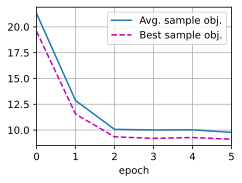

In [45]:
n_node = 100
n_ants = 20
k_sparse = 20
steps_per_epoch = 128
epochs = 5
net = train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, run_aco=False)

### TSP100-Stage2

total training duration: 2871.883518218994
epoch -1: (21.59347562789917, 19.65822916030884)
epoch 0: (12.23680944442749, 11.18034806251526)
epoch 1: (10.27629313468933, 9.466291332244873)
epoch 2: (9.920016527175903, 9.209163904190063)
epoch 3: (9.873479843139648, 9.136585235595703)
epoch 4: (9.739997005462646, 9.047240066528321)


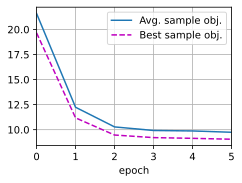

In [46]:
n_node = 100
n_ants = 20
k_sparse = 20
steps_per_epoch = 64
epochs = 5
net = train(n_node, k_sparse, n_ants, steps_per_epoch, epochs, run_aco=True, net=net)